In [2]:
import pennylane as qml
import numpy as np
import jax
from math import pi
import matplotlib.pyplot as plt

In [3]:
jax.config.update("jax_enable_x64", True)


default_wires = 8

dev = qml.device('default.qubit.jax', wires=default_wires)

#HWE
@qml.qnode(dev,interface="jax-jit")
def circuit(weights_gen, params_rand):

    for i in range(default_wires):
        qml.RZ(params_rand[i][1], wires=i)
        qml.RY(params_rand[i][0], wires=i)

    for d in range(weights_gen.shape[0]):
        for i in range(default_wires):
            qml.U3(weights_gen[d][i][0],weights_gen[d][i][1],weights_gen[d][i][2], wires=i)

        for i in range(int(default_wires/2)):
            qml.CZ(wires=[2*i,2*i+1])

        for i in range(default_wires):
            qml.U3(weights_gen[d][i][0],weights_gen[d][i][1],weights_gen[d][i][2], wires=i)

        for i in range(int((default_wires-1)/2)):
            qml.CZ(wires=[2*i+1,2*i+2])


    return qml.state()

#print(qml.draw(circuit)(weights_gen, params_rand) )        
        

/home/ryo_mtmt/.venv/lib/python3.10/site-packages/pennylane/devices/default_qubit_jax.py:173: PennyLaneDeprecationWarning: Use of 'default.qubit.jax' is deprecated. Instead, use 'default.qubit', which supports backpropagation. If you experience issues, reach out to the PennyLane team on the discussion forum: https://discuss.pennylane.ai/
  warnings.warn(
/home/ryo_mtmt/.venv/lib/python3.10/site-packages/pennylane/devices/default_qubit_legacy.py:211: PennyLaneDeprecationWarning: Use of 'default.qubit.jax' is deprecated. Instead, use 'default.qubit', which supports backpropagation. If you experience issues, reach out to the PennyLane team on the discussion forum: https://discuss.pennylane.ai/
  warnings.warn(
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
def concentratable_entanglement(state):
    power_set = []
    for i in range(1,2**default_wires): 
        subset = [j for j in range(default_wires) if (i & (1 << j))]
        power_set.append(subset)
    #print("powerset",power_set)

    purity_sum  = 0
    for subset in power_set:
        #縮約密度行列の取得
        #print("subset",subset)
        rho = qml.math.reduce_statevector(state,subset)
        #print("rho",rho)
        trace = np.trace(rho @ rho).real
        #print("TR[rho*rho]",trace)
        purity_sum += trace
    #空集合の場合
    purity_sum += 1

    CE = 1 - ( 1 / (2**default_wires))  * purity_sum
    return  CE

0 0.16303099025835455
1 0.29086802230244324
2 0.26593592277331013
3 0.16434382460345842
4 0.22828355394813316
5 0.13811535894528426
6 0.11434429688041547
7 0.07202872133806781
8 0.07733020488625619
9 0.150942523378082
10 0.14965767821358578
11 0.3031540974513034
12 0.23167586799975004
13 0.2103383877769155
14 0.07321835613542693
15 0.12754674038232827
16 0.22809688466769007
17 0.12679383456960014
18 0.1461484859568184
19 0.15260396405634136
20 0.2965756344289304
21 0.1165953151673571
22 0.16222631318294
23 0.28802727160626895
24 0.11088678441345956
25 0.12022982258621995
26 0.3324408750041551
27 0.11800883294013431
28 0.11844835744444793
29 0.3152833518933381
30 0.15694551457186656
31 0.06774472196342773
32 0.04039222916971874
33 0.3448156531890092
34 0.09190984082108611
35 0.2840647257909924
36 0.16995829497455828
37 0.27611850771665214
38 0.23861474727202225
39 0.3122635489645501
40 0.16179693332008505
41 0.17438613411049853
42 0.3966024943379226
43 0.13689725553434307
44 0.288510358

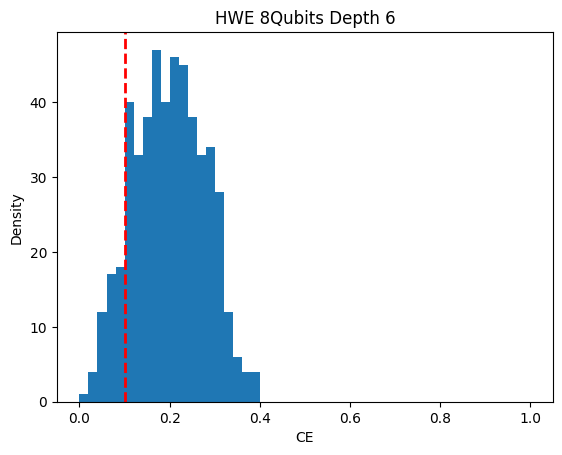

In [5]:
#HWE depth = 6 wires = 8
#実際は0.25だと 0.4 くらい　、　0.10 だと0.20くらい
#"0.25"
weights_gen = np.load('/home/ryo_mtmt/NTangled_Datasets/Hardware_Efficient/8_Qubits/Depth_6/hwe_8q_cb_25_6_weights.npy')

#weights_gen = np.load('/home/ryo_mtmt/NTangled_Datasets/Hardware_Efficient/8_Qubits/Depth_6/hwe_8q_cb_10_6_weights.npy')

x=[]

#print(qml.draw(circuit)(weights_gen, np.random.uniform(0, 2 * np.pi, (default_wires, 2))) )       

for i in range(500):
    params_rand = np.random.uniform(0, 2 * np.pi, (default_wires, 2))

    state = circuit(weights_gen, params_rand)
    x.append(concentratable_entanglement(state))
    
    print(i, x[i])


plt.hist(x,bins=50,range=(0, 1.0))

plt.title("HWE 8Qubits Depth 6")
plt.xlabel('CE')
plt.ylabel('Density')

plt.axvline(0.25, color='red', linestyle='dashed', linewidth=2, label=f'Theoretical mean: {0.05}')


print("平均", np.mean(x))

plt.show()





In [14]:
import csv
import numpy as np
import random 

weights_025_40 = np.load('/home/ryo_mtmt/NTangled_Datasets/Hardware_Efficient/8_Qubits/Depth_6/hwe_8q_cb_25_6_weights.npy')
weights_010_20 = np.load('/home/ryo_mtmt/NTangled_Datasets/Hardware_Efficient/8_Qubits/Depth_6/hwe_8q_cb_10_6_weights.npy')


optimal_ce_40 = 0.40
optimal_ce_20 = 0.20

#train だったらflag = true , test だったら flag = false

flag = True 

if flag:
    print("create train dataset")
    array = [-1] * 120 + [1] * 120
    file_name = 'train_HWE_8q_6_20_40.csv'
    count_limit = 240
else: 
    print("create test dataset")
    array = [-1] * 30 + [1] * 30
    file_name = 'test_HWE_8q_6_20_40.csv'
    count_limit = 60

random.shuffle(array)

count= 0

with open(file_name, mode = 'a', newline = '', encoding = 'utf-8') as file:

    writer = csv.writer(file)

    while count < count_limit:
        if array[count] == -1:
            optimal_ce = optimal_ce_20
            weights = weights_010_20
        else:
            optimal_ce = optimal_ce_40
            weights = weights_025_40

        params_rand = np.random.uniform(0, 2 * np.pi, (default_wires, 2))
        state = circuit(weights, params_rand)
        CE = concentratable_entanglement(state)

        if(abs(CE - optimal_ce) < 0.10):
            tmp_csv = params_rand.flatten()
            if array[count] == -1:
                tmp_csv = np.append(tmp_csv, -1)
                tmp_csv = np.append(tmp_csv, -1)
            else:
                tmp_csv = np.append(tmp_csv, 1)
                tmp_csv = np.append(tmp_csv, 1)
            writer.writerow(tmp_csv)

            count += 1
            print(count, CE)
        else:

            continue
    





create train dataset
1 0.2800046763131119
2 0.4961040924978357
3 0.40839964557983943
4 0.2824079129737834
5 0.41888724041676817
6 0.3786316777309068
7 0.2987434178620756
